In [1]:
import pandas as pd
import os
import sys
module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import pandas as pd
import nltk
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
import matplotlib.pyplot as plt
import string
import re
import numpy as np
from sklearn.model_selection import train_test_split
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score, precision_score, accuracy_score

In [2]:
# use this do download stopwords if you haven't done this before
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dermotobrien/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# loading in dataframe, using special encoder parameter to save it correctly
df = pd.read_csv('twitter_data.csv',encoding= 'unicode_escape')

In [4]:
# renaming the columns
df = df.rename(columns={"tweet_text": "tweet", "emotion_in_tweet_is_directed_at": "subject", "is_there_an_emotion_directed_at_a_brand_or_product": "emotion"})

In [5]:
df['tweet'] = df['tweet'].str.lower()

In [6]:
df_binary = df.loc[(df['emotion'] == 'Positive emotion' ) | (df['emotion'] == 'Negative emotion' )]

In [7]:
df_binary.loc[df_binary['emotion'] == 'Positive emotion' , 'emotion_label'] = 0
df_binary.loc[df_binary['emotion'] == 'Negative emotion' , 'emotion_label'] = 1

/Users/dermotobrien/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/dermotobrien/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/pandas/core/indexing.py:1765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [8]:
# function to label new column based on the product category 

def label_brand(row):
    if row['subject'] == 'iPad':
        return 'Apple'
    elif row['subject'] == 'Apple':
        return 'Apple'
    elif row['subject'] == 'iPad or iPhone App':
        return 'Apple'
    elif row['subject'] == 'iPhone':
        return 'Apple'
    elif row['subject'] == 'Other Apple product or service':
        return 'Apple'
    elif row['subject'] == 'Google':
        return 'Google'
    elif row['subject'] == 'Other Google product or service':
        return 'Google'
    elif row['subject'] == 'Android App':
        return 'Google'
    elif row['subject'] == 'Android':
        return 'Google'
    elif row['subject'] == np.nan: 
        return np.nan

In [9]:
df_binary['company'] = df_binary.apply(lambda row: label_brand(row), axis=1)

<ipython-input-9-3c2e651705a5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_binary['company'] = df_binary.apply(lambda row: label_brand(row), axis=1)


In [10]:
apple_words = ['apple','ipad','iphone','itunes']
google_words = ['google','android']

In [11]:
df_binary.loc[(df_binary['subject'].isna()) & (df_binary['tweet'].str.contains('|'.join(apple_words))),'company'] = 'Apple'

In [12]:
df_binary.loc[(df_binary['subject'].isna()) & (df_binary['tweet'].str.contains('|'.join(google_words))),'company'] = 'Google'

In [13]:
df_binary.dropna(subset=['company'],inplace=True)

<ipython-input-13-7638a198be87>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_binary.dropna(subset=['company'],inplace=True)


In [14]:
X_train, X_test, y_train, y_test = train_test_split(df_binary['tweet'], df_binary['emotion_label'], train_size=.9)

In [15]:
og_stopwords = stopwords.words('english')

## Baseline Model

In [16]:
tfidf_baseline = TfidfVectorizer(token_pattern=r"([a-zA-Z]+(?:'[a-z]+)?)",stop_words = og_stopwords)
baseline_vectorized = tfidf_baseline.fit_transform(X_train)

In [17]:
baseline_model = MultinomialNB()

In [18]:
# Evaluate the classifier on baseline_vectorized and y_train
baseline_cv = cross_val_score(baseline_model, baseline_vectorized, y_train)
baseline_cv.mean()

0.8429168764748279

In [19]:
# finding training score 
baseline_model.fit(baseline_vectorized,y_train)
baseline_train_score = baseline_model.score(baseline_vectorized,y_train)
print(baseline_train_score)

0.8592522777254162


In [20]:
#Evaluating recall
y_pred_baseline = baseline_model.predict(baseline_vectorized)
recall_score(y_train, y_pred_baseline)

0.13346228239845262

## Iteration 1: Decision Tree

In [21]:
tfidf_1 = TfidfVectorizer(token_pattern = r"([a-zA-Z]+(?:'[a-z]+)?)",stop_words = og_stopwords)
vectorized_1 = tfidf_1.fit_transform(X_train)

In [22]:
dt = DecisionTreeClassifier()

In [23]:
# Evaluate the classifier on basekube_vectorized and y_train
cv1 = cross_val_score(dt,vectorized_1, y_train)
cv1.mean()

0.8385222594117472

In [24]:
# finding training score 
dt.fit(vectorized_1,y_train)
dt1_score = dt.score(vectorized_1,y_train)
print(dt1_score)

0.9996858309770656


In [25]:
#Evaluating recall
y_pred_dt = dt.predict(baseline_vectorized)
recall_score(y_train, y_pred_baseline)

0.13346228239845262

## Iteration 2: Random Forest

In [26]:
tfidf_2 = TfidfVectorizer(token_pattern = r"([a-zA-Z]+(?:'[a-z]+)?)",stop_words = og_stopwords)
vectorized_2 = tfidf_2.fit_transform(X_train)

In [27]:
rf = RandomForestClassifier()

In [28]:
# Evaluate the random forest
cv2 = cross_val_score(rf,vectorized_2, y_train)
cv2.mean()

0.8649106957732295

In [29]:
# finding training score 
rf.fit(vectorized_2,y_train)
rf1_score = rf.score(vectorized_2,y_train)
print(rf1_score)

0.9993716619541313


In [30]:
#Evaluating recall
y_pred_rf = rf.predict(vectorized_2)
recall_score(y_train, y_pred_rf)

0.9980657640232108

## Iteration 3: Vectorizer 

In [31]:
tfidf_3 = TfidfVectorizer(token_pattern = r"([a-zA-Z]+(?:'[a-z]+)?)",
                          stop_words = og_stopwords,
                          ngram_range = (1,2),
                          min_df= 5
                         )
vectorized_3 = tfidf_3.fit_transform(X_train)

# five is the best input for our min_df parameter
# (1,2) is the best input for our ngram_range parameter

In [32]:
# Evaluate the random forest
cv3 = cross_val_score(rf,vectorized_3, y_train)
cv3.mean()

0.8639682868793381

In [33]:
# finding training score 
rf.fit(vectorized_3, y_train)
rf2_score = rf.score(vectorized_3, y_train)
print(rf2_score)

0.9996858309770656


In [34]:
#Evaluating recall
y_pred_rf2 = rf.predict(vectorized_3)
recall_score(y_train, y_pred_rf2)

0.9980657640232108

In [35]:
# looking at the shape of our tfidf sparse matrix
# pd.DataFrame.sparse.from_spmatrix(vectorized_3, columns=tfidf_3.get_feature_names()).shape

## Iteration 4 - Random Forest

In [36]:
tfidf_4 = TfidfVectorizer(token_pattern = r"([a-zA-Z]+(?:'[a-z]+)?)",
                          stop_words = og_stopwords,
                          ngram_range = (1,2),
                          min_df= 5
                         )
vectorized_4 = tfidf_4.fit_transform(X_train)

In [37]:
# grid search for random forest parameters
grid_rf1 = {"n_estimators":[100, 200, 300],
           "criterion": ["gini", "entropy", "log_loss"],
           "max_features": ["sqrt", "auto"],
           "max_depth" : [10,20,30,None],
            "min_samples_leaf" : [1,2,4],
            "min_samples_split": [2,5,10]
            }
GS_rf1 = GridSearchCV(
    estimator=rf,
    param_grid=grid_rf1,
    verbose=2)

In [38]:
# GS_rf1.fit(vectorized_4,y_train)

In [39]:
# GS_rf1.best_params_

{'criterion': 'gini',

'max_depth': None,

'max_features': 'auto',

'min_samples_leaf': 1,

'min_samples_split': 2,

'n_estimators': 200}

In [40]:
# GS_rf1.best_score_

0.8695299008634473

In [41]:
# grid search for random forest parameters
grid_rf2 = {"n_estimators":[150, 200, 250],
           "criterion": ["gini"],
           "max_features": ["auto"],
           "max_depth" : [None],
            "min_samples_leaf" : [1],
            "min_samples_split": [1,2,3]
            }
GS_rf2 = GridSearchCV(
    estimator=rf,
    param_grid=grid_rf2,
    n_jobs=-1,
    verbose=2)

In [42]:
GS_rf2.fit(vectorized_4,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    9.5s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    9.5s finished


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_depth': [None],
                         'max_features': ['auto'], 'min_samples_leaf': [1],
                         'min_samples_split': [1, 2, 3],
                         'n_estimators': [150, 200, 250]},
             verbose=2)

In [43]:
GS_rf2.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 200}

In [44]:
GS_rf2.best_score_

0.8671080043047699

In [45]:
# grid search for random forest parameters
grid_rf3 = {"n_estimators":[175, 200, 225],
           "criterion": ["gini"],
           "max_features": ["auto"],
           "max_depth" : [None],
            "min_samples_leaf" : [1],
            "min_samples_split": [3,4,5]
            }
GS_rf3 = GridSearchCV(
    estimator=rf,
    param_grid=grid_rf3,
    n_jobs=-1,
    verbose=2)

In [46]:
GS_rf3.fit(vectorized_4,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    9.0s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  45 out of  45 | elapsed:    9.0s finished


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini'], 'max_depth': [None],
                         'max_features': ['auto'], 'min_samples_leaf': [1],
                         'min_samples_split': [3, 4, 5],
                         'n_estimators': [175, 200, 225]},
             verbose=2)

In [47]:
GS_rf3.best_params_

{'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 200}

In [48]:
GS_rf3.best_score_

0.8655381455920541

In [49]:
rf3 = RandomForestClassifier(n_estimators=225,
                             criterion="gini",
                             max_depth=None,
                             min_samples_split=3,
                             min_samples_leaf=1,
                             max_features="auto")

In [50]:
# Evaluate the random forest
cv4 = cross_val_score(rf3, vectorized_4, y_train)
cv4.mean()

0.8636528341380092

In [51]:
# finding training score 
rf3.fit(vectorized_4, y_train)
rf3_score = rf3.score(vectorized_4, y_train)
print(rf3_score)

0.9987433239082626


In [52]:
#Evaluating recall
y_pred_rf3 = rf3.predict(vectorized_4)
recall_score(y_train, y_pred_rf3)

0.9922630560928434

## Incorporating Additional Stopwords

In [53]:
word_eval = pd.concat([X_train, y_train], axis=1)
word_eval_pos = word_eval.loc[word_eval["emotion_label"] == 0]
word_eval_neg = word_eval.loc[word_eval["emotion_label"] == 1]

### Positive Words

In [54]:
tfidf_pos = TfidfVectorizer(token_pattern = r"([a-zA-Z]+(?:'[a-z]+)?)",
                          stop_words = og_stopwords,
                          ngram_range = (1,2), min_df=5)

In [55]:
pos_vec = tfidf_pos.fit_transform(word_eval_pos["tweet"])

In [56]:
pos_matrix = pd.DataFrame.sparse.from_spmatrix(pos_vec, columns=tfidf_pos.get_feature_names())

In [57]:
pos_words_sorted = list(pos_matrix.mean(axis=0).sort_values(ascending=False).head(10).index)

### Negative Words

In [58]:
tfidf_neg = TfidfVectorizer(token_pattern = r"([a-zA-Z]+(?:'[a-z]+)?)",
                          stop_words = og_stopwords,
                          ngram_range = (1,2), min_df=5)

In [59]:
neg_vec = tfidf_neg.fit_transform(word_eval_neg["tweet"])

In [60]:
neg_matrix = pd.DataFrame.sparse.from_spmatrix(neg_vec, columns=tfidf_neg.get_feature_names())

In [61]:
neg_words_sorted = list(neg_matrix.mean(axis=0).sort_values(ascending=False).head(10).index)

### Shared Words

In [62]:
pos_words_sorted

['mention',
 'sxsw',
 'ipad',
 'link',
 'apple',
 'rt',
 'rt mention',
 'google',
 'iphone',
 'store']

In [63]:
neg_words_sorted

['sxsw',
 'mention',
 'ipad',
 'iphone',
 'quot',
 'google',
 'apple',
 'rt mention',
 'rt',
 'link']

In [64]:
shared_words = [word for word in pos_words_sorted if word in neg_words_sorted]
shared_words

['mention',
 'sxsw',
 'ipad',
 'link',
 'apple',
 'rt',
 'rt mention',
 'google',
 'iphone']

In [65]:
updated_stopwords = og_stopwords.copy()
updated_stopwords.extend(['sxsw', 'mention', 'link', 'apple', 'google', 'quot', 'rt', 'rt mention'])

## Iteration 5 - Random Forest with updated stopwords

In [66]:
tfidf_5 = TfidfVectorizer(token_pattern = r"([a-zA-Z]+(?:'[a-z]+)?)",
                          stop_words = updated_stopwords,
                          ngram_range = (1,2),
                          min_df= 5)

vectorized_5 = tfidf_5.fit_transform(X_train)

In [67]:
rf5 = RandomForestClassifier(n_estimators=225,
                             criterion="gini",
                             max_depth=None,
                             min_samples_split=3,
                             min_samples_leaf=1,
                             max_features="auto")

In [68]:
# Evaluate the random forest
cv5 = cross_val_score(rf5, vectorized_5, y_train)
cv5.mean()

0.871193092621664

In [69]:
# finding training score 
rf5.fit(vectorized_5, y_train)
rf5_score = rf5.score(vectorized_5, y_train)
print(rf5_score)

0.9943449575871819


In [70]:
# Evaluating recall
y_pred_rf5 = rf5.predict(vectorized_5)
recall_score(y_train, y_pred_rf5)

0.9729206963249516

### Recreate Positive and Negative Lists

#### Positive Words

In [71]:
tfidf_pos_2 = TfidfVectorizer(token_pattern = r"([a-zA-Z]+(?:'[a-z]+)?)",
                          stop_words = updated_stopwords,
                          ngram_range = (1,2), 
                          min_df=5)

pos_vec_2 = tfidf_pos_2.fit_transform(word_eval_pos["tweet"])

pos_matrix_2 = pd.DataFrame.sparse.from_spmatrix(pos_vec_2, columns=tfidf_pos_2.get_feature_names())

pos_words_sorted_2 = list(pos_matrix_2.mean(axis=0).sort_values(ascending=False).index)

In [72]:
# pos_words_sorted_2

#### Negative Words

In [73]:
tfidf_neg_2 = TfidfVectorizer(token_pattern = r"([a-zA-Z]+(?:'[a-z]+)?)",
                          stop_words = updated_stopwords,
                          ngram_range = (1,2), 
                          min_df=5)

neg_vec_2 = tfidf_neg_2.fit_transform(word_eval_neg["tweet"])

neg_matrix_2 = pd.DataFrame.sparse.from_spmatrix(neg_vec_2, columns=tfidf_neg_2.get_feature_names())

neg_words_sorted_2 = list(neg_matrix_2.mean(axis=0).sort_values(ascending=False).index)

In [74]:
# neg_words_sorted_2

## Wordcloud

In [75]:
pip install wordcloud

Note: you may need to restart the kernel to use updated packages.


In [76]:
from wordcloud import WordCloud
from PIL import Image

### Positive Wordcloud

In [113]:
custom_mask = np.array(Image.open("twitter_bw.png"))
pos_cloud = WordCloud(mask=custom_mask, 
                      background_color="white",
                      contour_color='black',
                      contour_width=3,
                      colormap='Greens', max_words=50).generate_from_frequencies(pos_matrix_2.T.sum(axis=1))

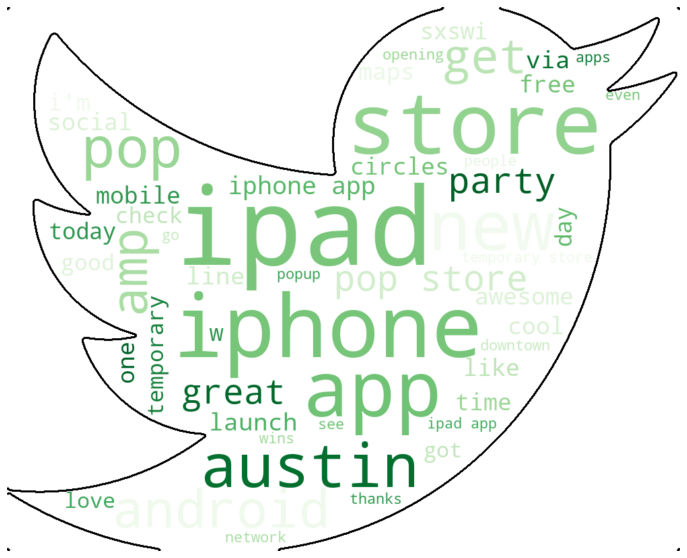

In [111]:
plt.figure(figsize=(15,10))
plt.imshow(pos_cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

### Negative Wordcloud

In [100]:
custom_mask = np.array(Image.open("twitter_dieded.png"))
neg_cloud = WordCloud(mask=custom_mask, 
                      colormap='Reds', 
                      background_color="white",
                      contour_color='black',
                      contour_width=3,
                      max_words=50).generate_from_frequencies(neg_matrix_2.T.sum(axis=1))

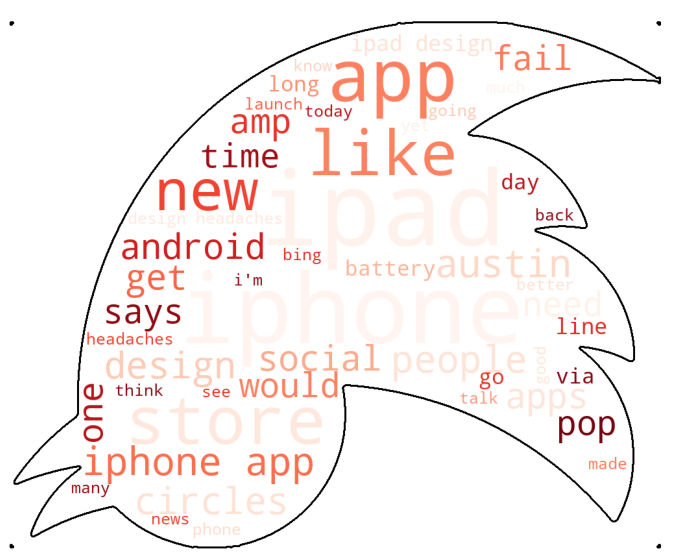

In [101]:
plt.figure(figsize=(15,10))
plt.clf()
plt.imshow(neg_cloud)
plt.axis('off')
plt.show()

## Iteration 6 - Random Forest max_depth adjustments

In [81]:
# Check max_depths of current random forest
[estimator.tree_.max_depth for estimator in rf5.estimators_]

[239,
 241,
 210,
 268,
 275,
 187,
 282,
 157,
 185,
 169,
 302,
 266,
 262,
 192,
 278,
 260,
 233,
 254,
 209,
 168,
 287,
 192,
 176,
 277,
 244,
 293,
 232,
 264,
 264,
 176,
 227,
 271,
 243,
 272,
 247,
 165,
 223,
 180,
 190,
 221,
 201,
 244,
 227,
 172,
 147,
 208,
 173,
 232,
 224,
 253,
 270,
 255,
 229,
 231,
 198,
 233,
 240,
 233,
 226,
 236,
 169,
 249,
 256,
 138,
 243,
 141,
 253,
 262,
 273,
 209,
 273,
 208,
 275,
 155,
 181,
 239,
 253,
 239,
 146,
 243,
 140,
 203,
 164,
 209,
 181,
 228,
 249,
 180,
 263,
 264,
 151,
 189,
 216,
 260,
 222,
 202,
 261,
 204,
 255,
 180,
 286,
 219,
 274,
 275,
 253,
 254,
 124,
 252,
 160,
 266,
 256,
 257,
 258,
 261,
 258,
 176,
 175,
 174,
 251,
 237,
 208,
 185,
 224,
 247,
 170,
 254,
 228,
 164,
 238,
 259,
 247,
 243,
 147,
 149,
 264,
 235,
 277,
 160,
 271,
 247,
 170,
 262,
 219,
 264,
 262,
 226,
 230,
 213,
 166,
 257,
 252,
 262,
 218,
 243,
 193,
 261,
 192,
 218,
 261,
 239,
 202,
 243,
 157,
 253,
 218,
 250,
 233

In [82]:
# grid search for random forest parameters
grid_rf4 = {"n_estimators":[225],
           "criterion": ["gini"],
           "max_features": ["auto"],
           "max_depth" : [50,100,150,200],
            "min_samples_leaf" : [1],
            "min_samples_split": [3]
            }
GS_rf4 = GridSearchCV(
    estimator=rf,
    param_grid=grid_rf4,
    n_jobs=-1,
    verbose=2,
    scoring='recall')

In [83]:
tfidf_6 = TfidfVectorizer(token_pattern = r"([a-zA-Z]+(?:'[a-z]+)?)",
                          stop_words = updated_stopwords,
                          ngram_range = (1,2),
                          min_df= 5,
                         )
vectorized_6 = tfidf_6.fit_transform(X_train)

In [84]:
GS_rf4.fit(vectorized_6, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   8 out of  20 | elapsed:    2.1s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:    4.0s finished


GridSearchCV(estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini'],
                         'max_depth': [50, 100, 150, 200],
                         'max_features': ['auto'], 'min_samples_leaf': [1],
                         'min_samples_split': [3], 'n_estimators': [225]},
             scoring='recall', verbose=2)

In [85]:
GS_rf4.best_params_

{'criterion': 'gini',
 'max_depth': 200,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 3,
 'n_estimators': 225}

In [86]:
GS_rf4.best_score_

0.31153846153846154

### Run Final Model on Test Set

In [87]:
test_vec = tfidf_5.transform(X_test)

In [88]:
# Evaluating recall
test_pred = rf5.predict(test_vec)
recall_score(y_test, test_pred)

0.38461538461538464

In [89]:
accuracy_score(y_test, test_pred)

0.8954802259887006

In [90]:
precision_score(y_test, test_pred)

0.8

In [91]:
rf5.score(test_vec, y_test)

0.8954802259887006